In [8]:
!pip install pyLDAvis==2.1.2 -q

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import gensim
from gensim import corpora
from gensim import models
from gensim.models import CoherenceModel

import pyLDAvis.gensim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# 1. Tokenization
def tokenize(tokens):  # Accept an individual article as input
    tokens = word_tokenize(tokens)  # Tokenize the article directly
    return tokens

# 2. Lowercasing
def lowercase(tokens):
    tokens = [token.lower() for token in tokens]
    return tokens

# 3. Stop Word Removal
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# 4. Punctuation Removal
def remove_punctuation(tokens):
    tokens = [token for token in tokens if token.isalpha()]
    return tokens

# 5. Lemmatization
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

# 6. Handling Numbers and Special Characters (optional)
def handle_numbers_special_chars(tokens):
    # Example: Remove numbers
    tokens = [token for token in tokens if not token.isdigit()]
    return tokens

# 7. Rare Word Removal
def remove_rare_words(tokens, min_freq=0.01):
    word_counts = nltk.FreqDist(tokens)
    tokens = [token for token in tokens if word_counts[token] >= min_freq * len(tokens)]
    return tokens

In [4]:
# Get the file path
file_path = '/content/TheHackerNews_Dataset.xlsx'

# Read the Excel file into a Pandas DataFrame
df = pd.read_excel(file_path)

# Print the head of the DataFrame
df.describe()

,Title,Link,Article,Label
count,3742,3742,3742,3742
unique,3223,3223,3224,4
top,FreakOut! Ongoing Botnet Attack Exploiting Rec...,https://thehackernews.com/2021/01/freakout-ong...,Data breaches and security incidents are a con...,Vulnerability
freq,3,3,3,1352


In [5]:
# Remove all other columns
df = df.drop(['Link', "Title",'Label'], axis=1)
df.head()

,Article
0,Cloud infrastructure security company Wiz on T...
1,"ShinyHunters, a notorious cybercriminal underg..."
2,Even as a massive data breach affecting Air In...
3,Bolstering password policies in your organizat...
4,Protection against insider risks works when th...


In [6]:
# Create an empty list to store preprocessed articles
processed_documents = []

# Iterate through each article in the DataFrame
for article in df['Article']:

    # Apply preprocessing steps individually to each article
    tokens = tokenize(article)
    tokens = lowercase(tokens)
    tokens = remove_stopwords(tokens)
    tokens = remove_punctuation(tokens)
    tokens = lemmatize(tokens)
    tokens = remove_rare_words(tokens)

    # Append the preprocessed article (as a list of tokens) to the list
    processed_documents.append(tokens)

In [7]:
# Create dictionary and corpus
dictionary = corpora.Dictionary(processed_documents)
corpus = [dictionary.doc2bow(doc) for doc in processed_documents]

In [8]:
results = []

for t in range(1, 31, 1):  # Will run trials between 1 and 30 topics, in increments of 1, can be changed
    lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=t, passes=10)
    corpus_lda = lda_model[corpus]

    # Use processed documents for coherence calculation
    texts = processed_documents

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, coherence='c_v', texts=texts)
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])
print(results)

    topic     score
0       1  0.230778
1       2  0.380509
2       3  0.366570
3       4  0.430711
4       5  0.385305
5       6  0.430228
6       7  0.454304
7       8  0.440996
8       9  0.441004
9      10  0.401196
10     11  0.406669
11     12  0.415098
12     13  0.406760
13     14  0.383219
14     15  0.398853
15     16  0.403148
16     17  0.407055
17     18  0.402311
18     19  0.396618
19     20  0.404952
20     21  0.411552
21     22  0.424021
22     23  0.384602
23     24  0.412725
24     25  0.380955
25     26  0.391709
26     27  0.394909
27     28  0.390991
28     29  0.409077
29     30  0.380761


Optimal topics: 7


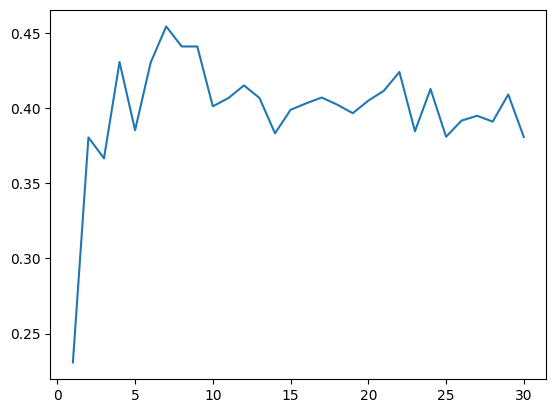

In [9]:
# Plotting Hyperparameter results and finding optimal topics
s = pd.Series(results.score.values, index=results.topic.values)
_ = s.plot()

index_of_highest_score = results['score'].idxmax()
value = results.loc[index_of_highest_score, 'topic']
print("Optimal topics:", value)

In [10]:
# Train the optimal LDA model
lda_model = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=value, passes=10)

In [11]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.259737 -0.035267       1        1  17.359290
4     -0.025034  0.315154       2        1  17.215516
2     -0.015557  0.053642       3        1  15.000464
0     -0.191103 -0.066202       4        1  14.596678
5      0.177887 -0.079554       5        1  14.257651
3     -0.103829 -0.123227       6        1  11.268245
1     -0.102100 -0.064546       7        1  10.302156, topic_info=              Term         Freq        Total Category  logprob  loglift
13   vulnerability  6699.000000  6699.000000  Default  30.0000  30.0000
165        malware  5572.000000  5572.000000  Default  29.0000  29.0000
1          account  2318.000000  2318.000000  Default  28.0000  28.0000
26      ransomware  1655.000000  1655.000000  Default  27.0000  27.0000
43        password  2184.000000  2184.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
889       backdoor   169.512038   494.725563   Topic7  -5.2227   1.2017
175       computer   205.996046  2005.063366   Topic7  -5.0278  -0.0028
139        service   183.199166  1231.536714   Topic7  -5.1451   0.3674
36          server   188.716950  2946.956225   Topic7  -5.1154  -0.4755
54          system   174.035195  4166.925418   Topic7  -5.1964  -0.9029

[506 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.070015  access
0         2  0.426694  access
0         3  0.053502  access
0         4  0.071336  access
0         5  0.324314  access
...     ...       ...     ...
188       4  0.533358    year
188       5  0.016825    year
188       7  0.089173    year
2708      3  0.007403    zeus
2708      7  0.991935    zeus

[1044 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 3, 1, 6, 4, 2])